In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from src.score import *

In [3]:
sns.set_style('darkgrid')
sns.set_context('notebook')

In [4]:
DATADIR = '/data/weather-benchmark/5.625deg/geopotential_500/'
PREDDIR = '/data/weather-benchmark/predictions/'

In [5]:
z500_validation = load_test_data(DATADIR)

/home/rasp/repositories/weather-benchmark/notebooks/src/score.py:24: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  ds = xr.open_mfdataset(f'{path}/*.nc')[var]
/home/rasp/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


## Load forecasts

In [37]:
fc_persistence = xr.open_dataset(f'{PREDDIR}/fc_persistence.nc').z
fc_climatology = xr.open_dataset(f'{PREDDIR}/fc_climatology.nc').z
fc_weekly_climatology = xr.open_dataset(f'{PREDDIR}/fc_weekly_climatology.nc').z

In [38]:
fc_lr_3d = xr.open_dataset(f'{PREDDIR}/fc_lr_3d.nc').__xarray_dataarray_variable__
fc_lr_5d = xr.open_dataset(f'{PREDDIR}/fc_lr_5d.nc').__xarray_dataarray_variable__
fc_lr_6h_iter = xr.open_dataset(f'{PREDDIR}/fc_lr_6h_iter.nc').__xarray_dataarray_variable__

In [39]:
fc_tigge = xr.open_dataset(f'{PREDDIR}/tigge_5.625deg.nc').__xarray_dataarray_variable__

In [99]:
fc_cnn_3d = xr.open_dataset(f'{PREDDIR}/fc_cnn_3d.nc').__xarray_dataarray_variable__
fc_cnn_5d = xr.open_dataset(f'{PREDDIR}/fc_cnn_5d.nc').__xarray_dataarray_variable__
# fc_cnn_6h_iter = xr.open_dataset(f'{PREDDIR}/fc_cnn_6h_iter.nc').__xarray_dataarray_variable__

In [103]:
fc_cnn_3d

<xarray.DataArray '__xarray_dataarray_variable__' (time: 17448, lat: 32, lon: 64)>
[35733504 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04 2017-01-04 ... 2017-01-04
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4

In [107]:
def create_training_data(data_train, lead_time_h, return_valid_time=False):
    X_train = data_train.isel(time=slice(0, -lead_time_h))
    y_train = data_train.isel(time=slice(lead_time_h, None))
    valid_time = y_train.time
    if return_valid_time:
        return X_train.values, y_train.values, valid_time
    else:
        return X_train.values, y_train.values

In [108]:
X_test, y_test, valid_time = create_training_data(z500_validation, 3*24, return_valid_time=True)

In [110]:
fc_cnn_3d['time'] = valid_time

In [114]:
rmse_cnn_3d, rmse_cnn_3d_no_period, rmse_cnn_3d_drop

(<xarray.DataArray ()>
 array(55664.8018826), <xarray.DataArray ()>
 array(648.58414477), <xarray.DataArray ()>
 array(2849.67281511))

In [40]:
rmses_persistence = evaluate_iterative_forecast(fc_persistence, z500_validation).load()
rmse_climatology = compute_weighted_rmse(fc_climatology, z500_validation).load()
rmse_weekly_climatology = compute_weighted_rmse(fc_weekly_climatology, z500_validation).load()

In [41]:
rmses_lr_6h_iter = evaluate_iterative_forecast(fc_lr_6h_iter, z500_validation).load()
rmse_lr_3d = compute_weighted_rmse(fc_lr_3d, z500_validation).load()
rmse_lr_5d = compute_weighted_rmse(fc_lr_5d, z500_validation).load()

In [111]:
# rmses_cnn_6h_iter = evaluate_iterative_forecast(fc_cnn_6h_iter, z500_validation).load()
rmse_cnn_3d = compute_weighted_rmse(fc_cnn_3d, z500_validation).load()
rmse_cnn_5d = compute_weighted_rmse(fc_cnn_5d, z500_validation).load()

In [42]:
rmses_tigge = evaluate_iterative_forecast(fc_tigge, z500_validation).load()

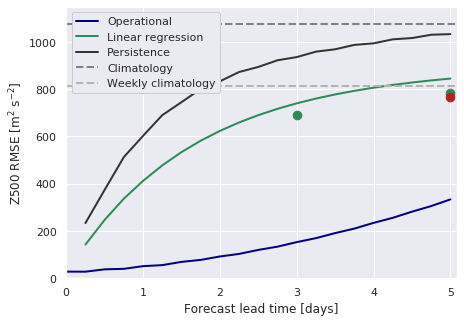

In [113]:
c_lr = 'seagreen'
c_cnn = 'firebrick'
c_tigge = 'navy'
c_persistence = '0.2'
c_climatology = '0.5'
c_weekly_climatology = '0.7'
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
rmses_tigge.plot(c=c_tigge, label='Operational', lw=2)
rmses_lr_6h_iter.plot(c=c_lr, label='Linear regression', lw=2)
# rmses_cnn_6h_iter.plot(c=c_cnn, label='CNN', lw=2)
rmses_persistence.plot(c=c_persistence, label='Persistence', lw=2)
ax.axhline(rmse_climatology, ls='--', c=c_climatology, label='Climatology', lw=2)
ax.axhline(rmse_weekly_climatology, ls='--', c=c_weekly_climatology, label='Weekly climatology', lw=2)
plt.scatter([3*24], [rmse_lr_3d], c=c_lr, s=75)
plt.scatter([5*24], [rmse_lr_5d], c=c_lr, s=75)
plt.scatter([3*24], [rmse_cnn_3d], c=c_cnn, s=75)
plt.scatter([5*24], [rmse_cnn_5d], c=c_cnn, s=75)
plt.legend(loc=2, framealpha=1)
plt.xlim(0, 122)
plt.ylim(0, 1150)
plt.xticks(range(0, 121, 24), range(0, 6))
plt.xlabel('Forecast lead time [days]')
plt.ylabel(r'Z500 RMSE [m$^2$ s$^{-2}$]');